In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from tqdm.notebook import tqdm
import math
import pickle
import gc
import json
import time

# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
# from torchgeometry.losses import dice_loss


# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [9]:
torch.manual_seed(3)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [10]:
class DualEnergyDataset:
    def __init__(self,
                 SE_dataroot='/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
                             '120kV/2021-12__Studies/drr/compound_rotations',
                 bone_dataroot='/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
                               'DE_subtracted/compund_rotations/bone',
                 soft_dataroot='/data/public/NANO_dual_energy/20211205_cirs_phantom_kvs/'\
                               'DE_subtracted/compund_rotations/soft',
                 common_shape_choice='mode'):
        
        SE_names = sorted(os.listdir(SE_dataroot))
        bone_names = sorted(os.listdir(bone_dataroot))
        soft_names = sorted(os.listdir(soft_dataroot))
        common_names = set(SE_names).intersection(set(bone_names)).intersection(set(soft_names))
        
        self.arr_list = []
        self.all_shapes = []
        for name in list(common_names)[:17]:
            with open(os.path.join(SE_dataroot, name), 'rb') as f:
                SE_arr = np.load(f)
            with open(os.path.join(bone_dataroot, name), 'rb') as f:
                bone_arr = np.load(f)
#             with open(os.path.join(soft_dataroot, name), 'rb') as f:
#                 soft_arr = np.load(f)
                
#             assert SE_arr.shape == bone_arr.shape == soft_arr.shape,\
#                    "All 3 arrays must have identical shapes"\
#                    f"but found {SE_arr.shape}, {bone_arr.shape}, {soft_arr.shape}"
            
            assert SE_arr.shape == bone_arr.shape,\
                   "All arrays must have identical shapes"\
                   f"but found {SE_arr.shape}, {bone_arr.shape}"
            
#             img = np.array([SE_arr, bone_arr, soft_arr])
            img = np.array([SE_arr, bone_arr])
            img = torch.from_numpy(img)
            self.arr_list.append(img)        
            self.all_shapes.extend([SE_arr.shape[0], SE_arr.shape[1]])
        
        self.common_shape_choice = common_shape_choice
        self.create_cropper()
        
    def create_cropper(self):
        if self.common_shape_choice == 'min':
            chosen_shape = min(self.all_shapes)
        elif self.common_shape_choice == 'median':
            chosen_shape = sorted(self.all_shapes)[len(self.all_shapes)//2]
        elif self.common_shape_choice == 'mode':
            chosen_shape = max(self.all_shapes, key=self.all_shapes.count)
        elif self.common_shape_choice == 'max':
            chosen_shape = max(self.all_shapes)
        elif isinstance(self.common_shape_choice, int):
            chosen_shape = sorted(self.all_shapes)[self.common_shape_choice]
        elif isinstance(self.common_shape_choice, float) and 0 < self.common_shape_choice < 1:
            chosen_shape = sorted(self.all_shapes)[int(self.common_shape_choice * len(self.all_shapes))]
        self.random_cropper = transforms.RandomCrop(chosen_shape, pad_if_needed=True)
    
    def __getitem__(self, i):
        single = self.arr_list[i][0]
        bone = self.arr_list[i][1]
#         soft = self.arr_list[i][1]
        noise = 0.25 * torch.std(single) * (torch.rand(single.shape) - 0.5)
#         noise = 0
        single_copy = torch.clone(single)
        single_copy= single_copy - torch.mean(single_copy) + noise
        single_copy /= torch.std(single_copy)
        single_copy *= -1
#         new_img = torch.stack((single_copy, bone, soft))
        new_img = torch.stack((single_copy, bone))
        new_img = self.random_cropper(new_img)
        return new_img
    
    def __len__(self):
        return len(self.arr_list)

In [11]:
# dual_energy_dataset = DualEnergyDataset(common_shape_choice=50)
dual_energy_dataset = DualEnergyDataset()

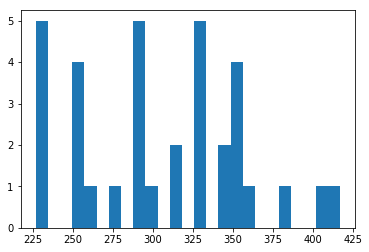

In [12]:
plt.hist(dual_energy_dataset.all_shapes, bins=25);

In [13]:
img = dual_energy_dataset[3]
img.shape

torch.Size([2, 230, 230])

Text(0.5,1,'(Dual Energy) Bone')

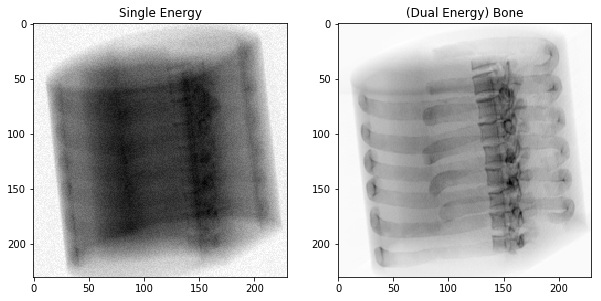

In [15]:
idx = np.random.randint(len(dual_energy_dataset))
# idx = 50
# single, bone, soft = dual_energy_dataset[idx]
single, bone = dual_energy_dataset[idx]
# stack = soft + bone
# fig, ax = plt.subplots(1, 4, figsize=(20, 15))
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(single, cmap='gray')
ax[0].set_title('Single Energy')
ax[1].imshow(bone, cmap='gray')
ax[1].set_title('(Dual Energy) Bone')
# ax[1].imshow(soft, cmap='gray')
# ax[1].set_title('(Dual Energy) Soft Tissue')
# ax[3].imshow(stack, cmap='gray')
# ax[3].set_title('Bone + Soft Tissue Stacked')

In [20]:
# basic unet with batch normalization
f_size = 7
padding = (f_size//2, f_size//2)
chs = [32, 64, 128, 256, 512] 

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, f_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, f_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
#         x = self.conv1(x.double())
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class UNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # pooling
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # ENCODER
        self.conv00 = ConvBlock(1, 32)
        self.conv10 = ConvBlock(32, 64)
        self.conv20 = ConvBlock(64, 128)
        self.conv30 = ConvBlock(128, 256)
        self.conv40 = ConvBlock(256, 512)
        
        # DECODER
        self.upconv31 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)
        self.conv31 = ConvBlock(2*256, 256)
        self.upconv22 = nn.ConvTranspose2d(256, 128, 3, stride=2)
        self.conv22 = ConvBlock(2*128, 128)
        self.upconv13 = nn.ConvTranspose2d(128, 64, 3, stride=2)
        self.conv13 = ConvBlock(2*64, 64)
        self.upconv04 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv04 = ConvBlock(2*32, 32)
        
        # final layers
#         self.final04 = nn.Conv2d(32, 2, 1)
        self.final04 = nn.Conv2d(32, 1, 1)
#         self.sigmoid_layer = nn.Sigmoid()
         
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x40 = self.conv40(self.pool(x30))
        
        
        # Up-sampling 
        x31 = self.upconv31(x40)
#         print(x30.shape, x31.shape)
        x31 = self.conv31(torch.cat((x30,x31), dim=1))
        x22 = self.upconv22(x31)
        x22 = self.conv22(torch.cat((x20,x22),dim=1))
        x13 = self.upconv13(x22)
        x13 = self.conv13(torch.cat((x10,x13),dim=1))
        x04 = self.upconv04(x13)
        x04 = self.conv04(torch.cat((x00,x04),dim=1))
        
        # Outputs
        x04 = self.final04(x04)

        
        return x04

In [21]:
generator_model = UNet().to(device)
datapoint = dual_energy_dataset[3][0]
unsqueezed = torch.unsqueeze(datapoint.to(device), 0)
unsqueezed = torch.unsqueeze(unsqueezed, 0)
fake = generator_model(unsqueezed.float())

Text(0.5,1,'Fake Bone')

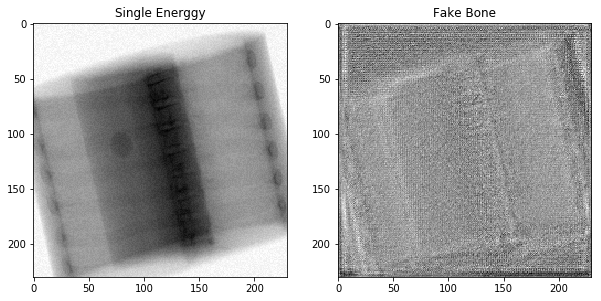

In [24]:
# fig, ax = plt.subplots(1, 3, figsize=(16, 16))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(unsqueezed.cpu().detach().numpy()[0][0], cmap='gray')
ax[0].set_title('Single Energgy')
ax[1].imshow(fake.cpu().detach().numpy()[0][0], cmap='gray')
ax[1].set_title('Fake Bone')
# ax[1].imshow(fake.cpu().detach().numpy()[0][0], cmap='gray')
# ax[1].set_title('Fake Soft Tissue')

In [25]:
class NLayerDiscriminator(nn.Module):
    """
    This class was inspired from 
    https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/
    Defines a PatchGAN discriminator
    """

    def __init__(self, input_nc, ndf=64, n_layers=4):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super().__init__()

        f_size = 4
        padding = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=f_size,
                              stride=2, padding=padding),
                    nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = 2 ** n
            sequence += [nn.Conv2d(ndf * nf_mult_prev,
                                   ndf * nf_mult,
                                   kernel_size=f_size,
                                   stride=2,
                                   padding=padding),
                         nn.BatchNorm2d(ndf * nf_mult),
                         nn.LeakyReLU(0.2, True)]

        nf_mult_prev = nf_mult
        nf_mult = 2 ** n_layers
        sequence += [nn.Conv2d(ndf * nf_mult_prev,
                               ndf * nf_mult,
                               kernel_size=f_size,
                               stride=1, padding=padding),
                     nn.BatchNorm2d(ndf * nf_mult),
                     nn.LeakyReLU(0.2, True)]

        sequence += [nn.Conv2d(ndf * nf_mult,
                               1, kernel_size=f_size,
                               stride=1, padding=padding)]  # output 1 channel prediction map
        
        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)

In [26]:
discriminator_model = NLayerDiscriminator(input_nc=2, n_layers=4).to(device)

In [27]:
unsqueezed.shape

torch.Size([1, 1, 230, 230])

In [28]:
fake.shape

torch.Size([1, 1, 230, 230])

In [29]:
rejoined = torch.cat((unsqueezed, fake), 1).float()
rejoined.shape

torch.Size([1, 2, 230, 230])

In [30]:
discriminator_model(rejoined).shape, discriminator_model(rejoined).mean()

(torch.Size([1, 1, 12, 12]),
 tensor(0.3410, device='cuda:1', grad_fn=<MeanBackward0>))

In [31]:
validation_frac = 0.1
validation_size = int(validation_frac * len(dual_energy_dataset))
train_size = len(dual_energy_dataset) - validation_size

train_dataset, validation_dataset = torch.utils.data.random_split(dual_energy_dataset,
                                                                  [train_size,
                                                                   validation_size])

In [32]:
batch_size = 16
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=batch_size,
                               shuffle=True)

In [33]:
classification_loss = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()
train_loss_dict = {'Generator':[], 'L1':[], 'Discriminator':[]}
# val_loss_dict = {'Generator':[], 'L1':[], 'Discriminator':[]}

def update_generator(preds, dual_energy, fake_dual_energy):
    gen_optimizer.zero_grad()
    discriminator_model.requires_grad = False
    
    # Generator walks in the opposite direction of discriminator
    # Hence the -1 factor
    loss_c = -1 * classification_loss(preds, torch.zeros(len(preds)).to(device))
    loss_L1 = lambda_L1 * L1_loss(dual_energy, fake_dual_energy)
    
    loss = loss_c + loss_L1

    loss.backward()
    gen_optimizer.step()
    train_loss_dict['Generator'].append(loss_c.item())
    train_loss_dict['L1'].append(loss_L1.item())
    
    discriminator_model.requires_grad = True

    
def update_discriminator(prediction_real, prediction_fake):
    disc_optimizer.zero_grad()
    generator_model.requires_grad = False
    
    combined_preds = torch.cat((prediction_real, prediction_fake), 0)
    label_tensor = torch.cat((torch.ones(len(prediction_real)),
                              torch.zeros(len(prediction_fake))),0)
    label_tensor = label_tensor.to(device)
    
    loss_c = lambda_discriminator * classification_loss(combined_preds, label_tensor)
    
    loss_c.backward()
    disc_optimizer.step()
    train_loss_dict['Discriminator'].append(loss_c.item())

    generator_model.requires_grad = True

In [34]:
num_epochs = 7200
learning_rate = 0.01
gen_optimizer = optim.Adam(generator_model.parameters(), lr=learning_rate)
# gen_scheduler = optim.lr_scheduler.StepLR(gen_optimizer, num_epochs//3)
disc_optimizer = optim.Adam(discriminator_model.parameters(), lr=learning_rate)
# disc_scheduler = optim.lr_scheduler.StepLR(gen_optimizer, num_epochs//3)
lambda_L1 = 10
lambda_discriminator = 2

In [35]:
gen_scheduler = optim.lr_scheduler.StepLR(gen_optimizer, num_epochs//3)
disc_scheduler = optim.lr_scheduler.StepLR(gen_optimizer, num_epochs//3)

In [36]:
for epoch in range(num_epochs):
    for batch_idx, train_batch in enumerate(train_loader):
        gc.collect()
        torch.cuda.empty_cache()

        real_data = train_batch.float().to(device)
        single_energy = torch.unsqueeze(real_data[:, 0, :, :], 1)
        dual_energy = real_data[:, 1:, :, :]


        fake_dual_energy = generator_model(single_energy)
        paired_fake = torch.cat((single_energy, fake_dual_energy), 1).float()

        prediction_fake = torch.mean(discriminator_model(paired_fake), (1, 2, 3))
        prediction_real = torch.mean(discriminator_model(real_data), (1, 2, 3))

        update_generator(prediction_fake.detach(), dual_energy, fake_dual_energy)
        update_discriminator(prediction_real, prediction_fake.detach())
        
        if not batch_idx % 3:
            print(f'Epoch {epoch:02d}, batch {batch_idx:04d}', end='\r')
    
    gen_scheduler.step()
    disc_scheduler.step()

In [25]:
# time_stamp = time.strftime('%d_%b_%y-%H:%M:%S')
# logs_filename = f'pix2pixlogs({time_stamp}).json'
# print(f'Logs saved at {logs_filename}')
# with open(logs_filename, 'w') as f:
#     json.dump(train_loss_dict, f)

In [37]:
train_losses_soft = train_loss_dict.copy()

In [38]:
def smoothing(lst, window=None):
    if window is None:
        window = len(lst) // 20
    smooth_lst = [sum(lst[i:i+window])/len(lst[i:i+window]) for i in range(0, len(lst), window)]
    return smooth_lst

for k, v in train_loss_dict.items():
    train_losses_soft[k] = smoothing(v, window=4)

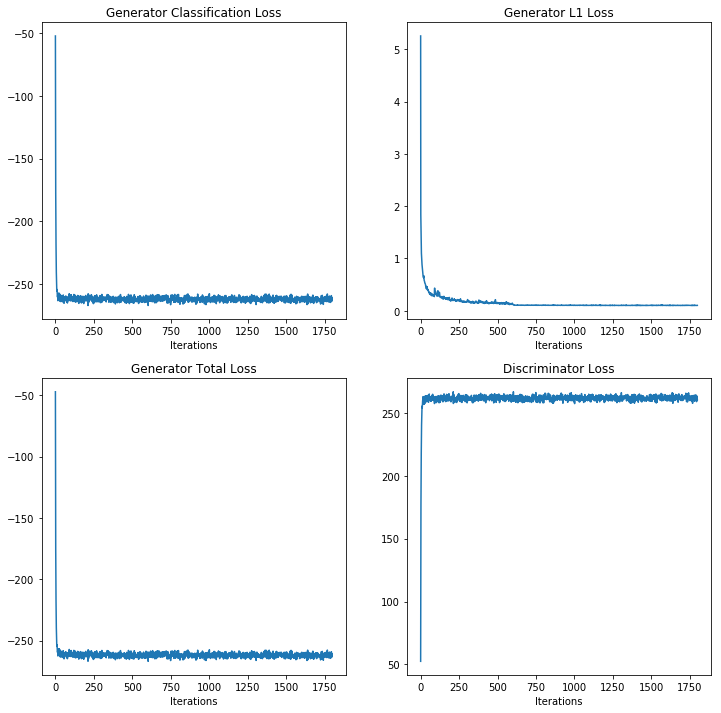

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0][0].plot(train_losses_soft['Generator']);
ax[0][0].set_title('Generator Classification Loss');
ax[0][0].set_xlabel('Iterations');

ax[0][1].plot(train_losses_soft['L1']);
ax[0][1].set_title('Generator L1 Loss');
ax[0][1].set_xlabel('Iterations');

generator_combined = [L1 + Lc for L1, Lc in 
                      zip(train_losses_soft['Generator'],
                          train_losses_soft['L1'])]

ax[1][0].plot(generator_combined);
ax[1][0].set_title('Generator Total Loss');
ax[1][0].set_xlabel('Iterations');

ax[1][1].plot(train_losses_soft['Discriminator']);
ax[1][1].set_title('Discriminator Loss');
ax[1][1].set_xlabel('Iterations');

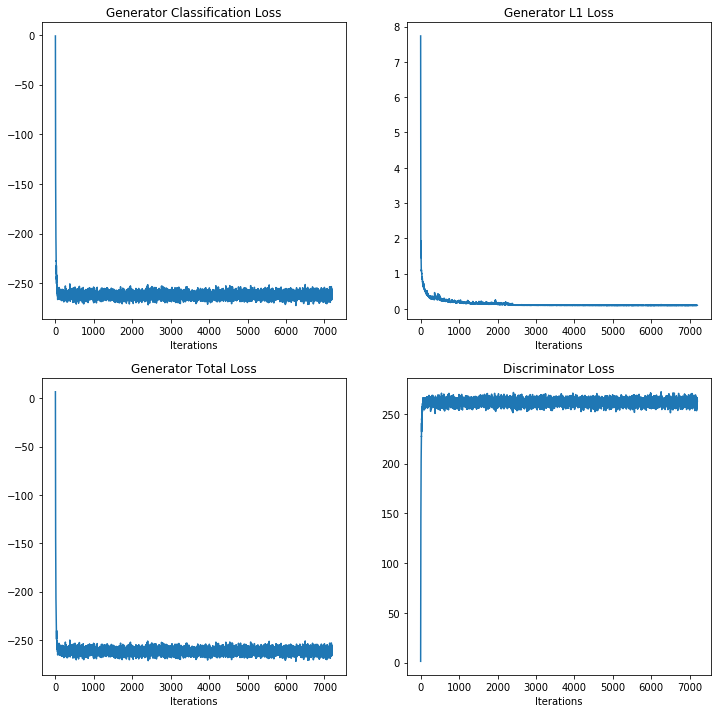

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0][0].plot(train_loss_dict['Generator']);
ax[0][0].set_title('Generator Classification Loss');
ax[0][0].set_xlabel('Iterations');

ax[0][1].plot(train_loss_dict['L1']);
ax[0][1].set_title('Generator L1 Loss');
ax[0][1].set_xlabel('Iterations');

generator_combined = [L1 + Lc for L1, Lc in 
                      zip(train_loss_dict['Generator'],
                          train_loss_dict['L1'])]

ax[1][0].plot(generator_combined);
ax[1][0].set_title('Generator Total Loss');
ax[1][0].set_xlabel('Iterations');

ax[1][1].plot(train_loss_dict['Discriminator']);
ax[1][1].set_title('Discriminator Loss');
ax[1][1].set_xlabel('Iterations');

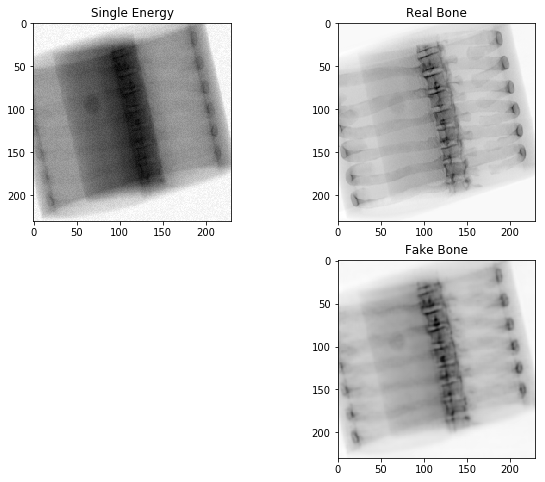

In [71]:
with torch.no_grad():
    val_data = next(iter(train_loader))
    
    single_energy = torch.unsqueeze(val_data[:, 0, :, :], 1)
    fake_data = generator_model(single_energy.float().to(device))

    single_energy_sample = single_energy[0][0]
    real_bone_sample = val_data[0, 1, :, :]
#     real_soft_sample = val_data[0, 2, :, :]
#     real_soft_sample = val_data[0, 1, :, :]
    fake_bone_sample = fake_data[0][0]
#     fake_soft_sample = fake_data[0][0]
    
#     fig, ax = plt.subplots(2, 3, figsize=(16, 8))
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    ax[0][0].imshow(single_energy_sample.cpu().detach().numpy(), cmap='gray')
    ax[0][0].set_title('Single Energy')
    
    ax[0][1].imshow(real_bone_sample.cpu().detach().numpy(), cmap='gray')
    ax[0][1].set_title('Real Bone')
    
#     ax[0][1].imshow(real_soft_sample.cpu().detach().numpy(), cmap='gray')
#     ax[0][1].set_title('Real Soft Tissue')
    
    ax[1][0].set_visible(False)
    
    ax[1][1].imshow(fake_bone_sample.cpu().detach().numpy(), cmap='gray')
    ax[1][1].set_title('Fake Bone')
    
#     ax[1][1].imshow(fake_soft_sample.cpu().detach().numpy(), cmap='gray')
#     ax[1][1].set_title('Fake Soft Tissue')

In [ ]:
#!git add pix2pix.ipynb;git commit -m "Input normalization + dynamic random augmentations 2"; git push

In [ ]:
# time_stamp = time.strftime('%d_%b_%y-%H:%M:%S')
# torch.save(generator_model.state_dict(), f'generator_model({time_stamp}).pt')

In [ ]:
# time_stamp

In [ ]:
# logs_filename = f'pix2pixlogs({time_stamp}).json'
# print(f'Logs saved at {logs_filename}')
# with open(logs_filename, 'w') as f:
#     json.dump(train_loss_dict, f)